In [65]:
import os
import pandas as pd
from langchain_google_genai import  ChatGoogleGenerativeAI

from langchain.agents.agent_types import AgentType
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent


In [66]:
# Google Gemini API key
os.environ["GOOGLE_API_KEY"] = "__GOOGLE_KEY__"
llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro", temperature=0)

In [67]:
filename = "/Users/dnayal/Downloads/BankChurners.csv"

str = ""
with open(filename, "r") as file:
    str = file.readline()

response = llm.invoke(
    "context: this is the first line of a CSV file. In your response, mention what the separator of this CSV file is. You response should only contain the separator - nothing else at all." +
    "\n csv_line: " + str
)
separator = response.content.strip()
separator

','

In [68]:
df = pd.read_csv(filename, sep=separator)

pandas_agent = create_pandas_dataframe_agent(llm, df, verbose=True, allow_dangerous_code=True)
pandas_agent.invoke("How many rows are there?")["output"]



> Entering new AgentExecutor chain...
Thought: I can use the `len` function on the dataframe to find the number of rows.
Action: python_repl_ast
Action Input: `len(df)`10127Thought: I now know the final answer.
Final Answer: 10127


> Finished chain.


'10127'

## creating graph state

In [85]:

llm_with_tools = llm.bind_tools([pandas_agent])

Key 'title' is not supported in schema, ignoring


In [90]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import AnyMessage, add_messages
from langchain_core.tools import tool

class State(TypedDict):
    messages: Annotated[list, add_messages]

def chatbot(state: State):
    msg = state["messages"]
    return {"messages":llm_with_tools.invoke(msg)}


In [91]:
from langgraph.graph import StateGraph, START, END

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()

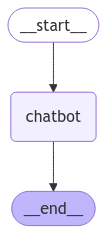

In [92]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [93]:
from langchain_core.messages import HumanMessage

graph.invoke({"messages":HumanMessage("What is your name?")})

ChatGoogleGenerativeAIError: Invalid argument provided to Gemini: 400 * GenerateContentRequest.tools[0].function_declarations[0].parameters.properties[input].type: must be specified when not using one_of
